In [ ]:
import pandas as pd
from google.colab import files
import io
import re
import string
import seaborn as sns

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score

In [ ]:
uploaded = files.upload()
raw_df = pd.read_csv(io.BytesIO(uploaded['Suicide_Detection.csv']))

Saving Suicide_Detection.csv to Suicide_Detection.csv


In [ ]:
raw_df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


Data Understanding and Wrangling

In [ ]:
df = raw_df.drop(columns = ['Unnamed: 0'])
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
#Lowercase the text
df['text']=df['text'].apply(lambda x: x.lower())

In [ ]:
#Remove digits and words containing digits
df['text']=df['text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
#Remove Punctuations
df['text']=df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))


In [ ]:
df.head()

,text,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i don't get affected by compliments...,non-suicide
2,finally 2020 is almost over... so i can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"i’m so losthello, my name is adam (16) and i’v...",suicide


## Exploratory Data Analysis (EDA)

In [ ]:
stops = stopwords.words('english')

In [ ]:
def remove_punc(string):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    for ele in string:  
        if ele in punc:  
            string = string.replace(ele, "") 
    return string
 
stop_words = [remove_punc(i) for i in stops]


In [ ]:
stop_words.append('im')

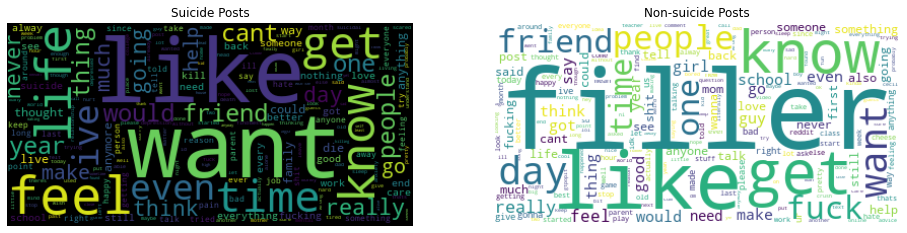

In [ ]:
#check words related to suicide
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_sui = " ".join(df['text'][df['class'] == 'suicide'])
text_nonsui = " ".join(df['text'][df['class'] == 'non-suicide'])
train_cloud_pos = WordCloud(collocations = False, background_color = 'black', stopwords = stop_words).generate(text_sui)
train_cloud_neg = WordCloud(collocations = False, background_color = 'white', stopwords = stop_words).generate(text_nonsui)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Suicide Posts')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Non-suicide Posts')

plt.show()

In [ ]:
#check words in each review
df["Words per post"] = df["text"].str.split().apply(len)
df["Words per post"].describe()

count    232074.000000
mean        130.474482
std         213.747609
min           0.000000
25%          25.000000
50%          59.000000
75%         153.000000
max        9684.000000
Name: Words per post, dtype: float64

In [ ]:
#remove posts with lots of words
#tweet limit char is 280 
df2 = df[df['Words per post'] < 300]

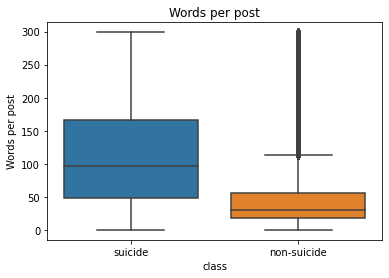

In [ ]:
sns.boxplot(x="class", y="Words per post", data = df2)
plt.title('Words per post')
plt.show()

**EDA Conclusions**
- Posts with suicidal tendencies contain more words about life, time, opposition/rejection
- Posts with suicidal tendencies may have more words

## Text Preproessing and Modelling

In [ ]:
inputs = df['text']
labels = pd.get_dummies(df['class'])['suicide']

inputs_train, inputs_test, Ytrain, Ytest = train_test_split(inputs, labels, random_state = 157)

inputs_train.shape, inputs_test.shape

((174055,), (58019,))

In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
    
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos = get_wordnet_pos(tag)) for word, tag in words_and_tags]

In [ ]:
vectorize = CountVectorizer(stop_words='english',tokenizer=LemmaTokenizer(),decode_error = 'ignore') 

In [ ]:
Xtrain = vectorize.fit_transform(inputs_train)
Xtest = vectorize.transform(inputs_test)

Xtrain.shape,Xtest.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  % sorted(inconsistent)


((174055, 167142), (58019, 167142))

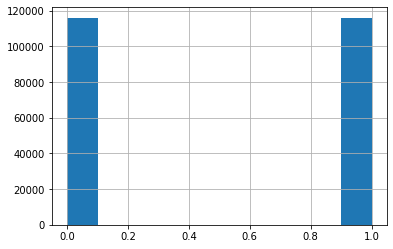

In [ ]:
#check class balance
labels.hist()

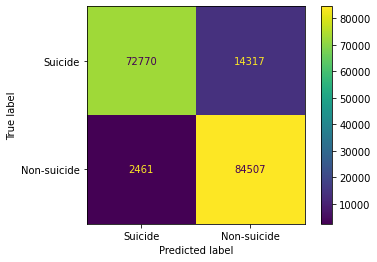

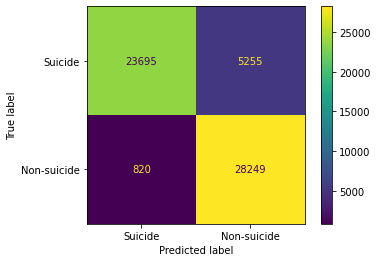

In [ ]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
Ypred = model.predict(Xtest)
Ytrain_pred = model.predict(Xtrain)

cm_train = confusion_matrix(Ytrain, Ytrain_pred)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = ['Suicide', 'Non-suicide'])
cm_display_train.plot()

cm_test = confusion_matrix(Ytest, Ypred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = ['Suicide', 'Non-suicide'])
cm_display.plot()

In [ ]:
#acc
print('The accuracy of training data: ', accuracy_score(Ytrain, Ytrain_pred))
print('The accuracy of testing data: ', accuracy_score(Ytest, Ypred))

The accuracy of training data:  0.9036051822699721
The accuracy of testing data:  0.8952929212844069


In [ ]:
#precision & recall
print('The precision of training data: ', precision_score(Ytrain, Ytrain_pred))
print('The precision of testing data: ', precision_score(Ytest, Ypred))

print('The recall of training data: ', recall_score(Ytrain, Ytrain_pred))
print('The recall of testing data: ', recall_score(Ytest, Ypred))

The precision of training data:  0.855126285112928
The precision of testing data:  0.8431530563514804
The recall of training data:  0.9717022353049397
The recall of testing data:  0.9717912552891397


Intrepret the model with weight

In [ ]:
model.coef_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


array([[-15.82873804, -15.82873804, -15.82873804, ..., -15.82873804,
        -15.82873804, -15.82873804]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


(array([5.4312e+04, 7.2027e+04, 1.1957e+04, 8.4700e+03, 3.7230e+03,
        3.8160e+03, 2.3870e+03, 2.3010e+03, 1.5080e+03, 1.3850e+03,
        1.0370e+03, 8.7200e+02, 6.7200e+02, 6.0700e+02, 4.5600e+02,
        3.7800e+02, 2.8900e+02, 2.3100e+02, 2.0000e+02, 1.4000e+02,
        1.1800e+02, 9.7000e+01, 5.9000e+01, 3.2000e+01, 2.3000e+01,
        1.7000e+01, 1.2000e+01, 7.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([-15.82873804, -15.4249678 , -15.02119756, -14.61742732,
        -14.21365708, -13.80988684, -13.4061166 , -13.00234636,
        -12.59857612, -12.19480588, -11.79103564, -11.3872654 ,
        -10.98349516, -10.57972492, -10.17595468,  -9.77218443,
         -9.36841419,  -8.96464395,  -8.56087371,  -8.15710347,
         -7.75333323,  -7.34956299,  -6.94579275,  -6.54202251,
         -6.13825227,  -5.73448203,  -5.33071179,  -4.92694155,
         -4.52317131,  -4.11940107,  -3.71563083]),
 <a list of 30 Patch objects>)

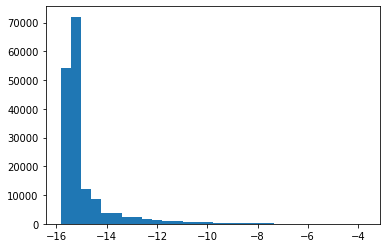

In [ ]:
plt.hist(model.coef_[0], bins = 30)

highly right_skewed

In [ ]:
word_index_map = vectorize.vocabulary_

In [ ]:
threshold = -6

print("Most suicide-related words:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold:
        print(word,weight)

Most suicide-related words:
say -5.183646533881719
want -4.132075356340641
talk -5.437069327428421
know -4.3812368238856845
care -5.654918055593189
time -4.765746948107882
year -4.90508634737089
like -4.305594955415341
fuck -5.348468600281178
tell -5.191825462651343
love -5.51516274911625
people -4.917803648793862
really -5.031982764993243
thought -5.908196735144029
hate -5.8761746520632645
’ -3.7156308275936727
s -5.493597951848045
just -3.895393177385783
need -5.556311062951144
help -5.2050719700988815
ve -5.971032682364985
thing -5.015944091610148
bad -5.390337314414808
good -5.17903658821322
long -5.935806003649374
didnt -5.984257670289891
think -4.70811469885764
come -5.759270058129022
friend -4.987981351450511
job -5.8520464974514415
work -5.44492531139225
make -4.801685459686171
try -4.990373556360023
leave -5.698593119095852
dont -4.264729805046441
point -5.929660198198558
kill -5.3006230782817205
ive -4.878563273906668
feel -4.320573894377468
day -5.155721139231106
end -5.3389

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
